In [138]:
import matplotlib.patches as ptc
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

import os
from pathlib import Path

dataDir = str(Path(os.getcwd()).parent) + '/Data/'

import scipy.stats as sts
import numpy as np
import pandas as pd

## OLS

In [139]:
class Ols:
    def __init__(self, addIntercept = True):
        self.addIntercept = addIntercept
        
    def train(self, X, Y):
        Xpred = self.getFullPredictorMatrix(X)
        betaFull = np.dot(np.dot(np.linalg.inv(np.dot(Xpred.T, Xpred)), Xpred.T), Y)
        
        K = Y.shape[1]
        p = X.shape[1]
        self.beta = betaFull[0:p,:]
        self.intercept = betaFull[p,:] if self.addIntercept else 0.0
        
    def predict(self, X):
        return self.intercept + np.dot(X, self.beta)
            
    def getFullPredictorMatrix(self, X):
        if not self.addIntercept:
            return X
        N, p = X.shape
        Xcomplete = np.zeros((N, p + 1))
        Xcomplete[:,0:p] = X
        Xcomplete[:,p] = 1.0
        return Xcomplete

## Best subset

In [140]:
def allSubsetsIndices(p, M):
    subList = [-1] * M
    subLists = []
    
    addAllSubsets(subList, subLists, p, 0, M, 0)
    return subLists
    
def addAllSubsets(subList, subLists, p, iStart, Mremaining, k):
    if Mremaining == 0:
        subLists.append(list(subList))
        return
    
    for i in range(iStart, p - Mremaining + 1):
        subList[k] = i
        addAllSubsets(subList, subLists, p, i + 1, Mremaining - 1, k + 1)

In [141]:
class BestSubset:    
    def __init__(self, subsetSize, modelFactory = lambda: Ols(), penalty = lambda Yr: np.sum(Yr * Yr)):
        self.subsetSize = subsetSize
        self.modelFactory = modelFactory
        self.penalty = penalty
    
    def train(self, X, Y):
        allSubsets = allSubsetsIndices(X.shape[1], self.subsetSize)
        minPenalty = np.inf
        for subset in allSubsets:
            Xsub = X[:, subset[::1]]
            model = self.modelFactory()
            model.train(Xsub, Y)
            Yhat = model.predict(Xsub)
            penalty = self.penalty(Y - Yhat)
            if penalty < minPenalty:
                minPenalty = penalty
                self.bestSubset = subset
                self.bestModel = model
                
    def predict(self, X):
        return self.bestModel.predict(X[:,self.bestSubset[::1]])

## Ridge

In [214]:
def monotonicBisection(f, x0Left, x0Right, fTolerance, maxIterations = 1000):
    i = 0
    xLeft = x0Left
    xRight = x0Right
    
    fLeft = f(xLeft)
    fRight = f(xRight)
    
    if fLeft == 0:
        return x0Left
    if fRight == 0:
        return x0Right
    if xLeft == xRight or fLeft == fRight:
        raise Exception('Wrong initialization')
    
    increasing = (fRight > fLeft)
    #print("")
    while fRight * fLeft > 0 and i < maxIterations: 
        #print("{0}:{1}  - {2}:{3}".format(xLeft, fLeft, xRight, fRight))
        if (fRight < 0) == increasing:
            xRight = 2 * xRight - xLeft
            fRight = f(xRight)
        else:
            xLeft = 2 * xLeft - xRight
            fLeft = f(xLeft)
        i = i + 1
        
    if i == maxIterations:
        raise Exception('Ran out of iterations while looking for initial conditions')
    
    while max(abs(fLeft), abs(fRight)) > fTolerance and i < maxIterations:
        #print("{0}:{1}  - {2}:{3}".format(xLeft, fLeft, xRight, fRight))
        xMiddle = 0.5 * (xRight + xLeft)
        fMiddle = f(xMiddle)
        if fMiddle == 0:
            return xMiddle
        
        if fMiddle * fRight > 0:
            xRight = xMiddle
            fRight = fMiddle
        else:
            xLeft = xMiddle
            fLeft = fMiddle
        
        i = i + 1
        
    if i == maxIterations:
        raise Exception('Ran out of iterations while bisecting')
    return (xRight + xLeft) / 2

In [218]:
class Ridge:
    def __init__(self, ndof):
        self.ndof = ndof
        
    def train(self, X, Y):
        self.Xmean = np.expand_dims(np.average(X, axis = 0), axis = 0)
        Xnorm = X - self.Xmean
        self.Xsd = np.expand_dims(np.sqrt(np.average(X * X, axis = 0)), axis = 0)
        Xnorm = Xnorm / self.Xsd
        self.Ymean = np.expand_dims(np.average(Y, axis = 0), axis = 0)
        
        betaMatrix = lambda lmbd: np.dot(np.linalg.inv(np.dot(Xnorm.T, Xnorm) + lmbd * np.identity(Xnorm.shape[1])), Xnorm.T) 
        ndofLambda = lambda lmbd: np.trace(np.dot(Xnorm, betaMatrix(lmbd)))
        
        if self.ndof == X.shape[1]:
            self.lmbd = 0
            self.beta = np.dot(betaMatrix(self.lmbd), Y)
        elif self.ndof > 0:
            nu = monotonicBisection(lambda n: ndofLambda(np.exp(n)) - self.ndof, 0, 1, 0.0001)
            self.lmbd = np.exp(nu)
            self.beta = np.dot(betaMatrix(self.lmbd), Y)
        else:
            self.lmbd = np.inf
            self.beta = np.zeros((X.shape[1], Y.shape[1]))
                             
    def predict(self, X):
        return self.Ymean + np.dot((X - self.Xmean) / self.Xsd, self.beta)

In [36]:
data = pd.read_csv(dataDir + 'prostate.data', delimiter = '\t')

# dropping index column
data = data.drop(data.columns[0], axis = 1)

data.columns

Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45',
       'lpsa', 'train'],
      dtype='object')

In [37]:
data_preds = data.copy(deep=True)
data_preds = data_preds.drop('lpsa', axis = 1).drop('train', axis = 1)
predNames = list(data_preds)

X = np.array(data_preds)
Y = np.expand_dims(np.array(data['lpsa']), axis = 1)
train = np.array([True if x == 'T' else False for x in data['train']])

X_train = X[train]
Y_train = Y[train]
X_test = X[np.logical_not(train)]
Y_test = Y[np.logical_not(train)]

In [38]:
results = pd.DataFrame()
results['Value'] = predNames + ['Test Error', 'Std Error']

## Basic helpers

In [5]:
# data folder: splits N rows in NFolds folds, (NFolds - 1) of which have the same size, fixed to be the
# maximum size such that the last fold is at least as large.

class DataFolder:
    def __init__(self, N, NFolds, seed = 0, permute = True):
        self.N = N
        self.NFolds = NFolds
        np.random.seed(seed)
        self.indices = (np.random.permutation(N) if permute else np.array(range(N)))       
        self.smallFoldSize = int(N / NFolds)
    
    def getFoldPair(self, foldIndex, Z):
        IFoldStart = foldIndex * self.smallFoldSize
        IFoldEnd = (foldIndex + 1) * self.smallFoldSize if foldIndex < self.NFolds - 1 else self.N
        
        NFold = IFoldEnd - IFoldStart
        foldData = Z[(self.indices[IFoldStart:IFoldEnd])[::1],:]
        foldExclData = np.zeros((self.N - NFold,Z.shape[1]))
        foldExclData[0:IFoldStart,:] = Z[(self.indices[0:IFoldStart])[::1],:]
        foldExclData[IFoldStart:self.N - NFold,:] = Z[(self.indices[IFoldEnd:self.N])[::1],:]
        
        return foldData, foldExclData
    

def RsStats(model, X, Y):
    Yhat = model.predict(X)
    rs = (Y - Yhat) * (Y - Yhat)
    return {"avg": np.average(rs), "stdev": np.sqrt(np.var(rs) / (X.shape[0] - 1))}

def bcorrs(X, Y):
    return np.dot(X.T, Y) / np.sqrt(np.expand_dims(np.sum(X * X, axis = 0), axis = 1) * np.expand_dims(np.sum(Y * Y, axis = 0), axis = 0))



In [63]:
# stats(Y, Yhat)
def CVStats(locModel, X, Y, NFolds, statsFn, permute = True, seed = 0):
    N = X.shape[0]
    df = DataFolder(N, NFolds, seed, permute)
    cvErrors = []
    for fIndex in range(NFolds):
        Xfold, XfoldExcl = df.getFoldPair(fIndex, X_train)
        Yfold, YfoldExcl = df.getFoldPair(fIndex, Y_train)
        locModel.train(XfoldExcl, YfoldExcl)
        cvErrors.append(statsFn(Yfold, locModel.predict(Xfold)))
    
    return cvErrors

## Least squares

In [65]:
model = Ols(addIntercept = True)
model.train(X_train, Y_train)
testStats = RsStats(model, X_test, Y_test)
model.testError = testStats["avg"]
model.testErrorStdev = testStats["stdev"]
tunedModels = {}
tunedModels["LS"] = model

## Best subset

In [134]:
Mmin = 0
Mmax = X_train.shape[1]
NFolds = 10
cvStats = lambda Y, Yhat: [Y.shape[0], np.average((Y - Yhat)*(Y - Yhat))]

model = BestSubset(subsetSize = -1)

stats = {}
candidateMs = np.array(range(Mmin, Mmax + 1))
for M in candidateMs:
    model.subsetSize = M
    stats[M] = CVStats(model, X_train, Y_train, NFolds, cvStats, permute = True, seed = 0)
    
cvErrors = [sum([x[1] * x[0] for x in value]) / X_train.shape[0] for key, value in stats.items()]
cvStdevs = [np.sqrt(np.var([x[1] for x in value]) / NFolds) for key, value in stats.items()]

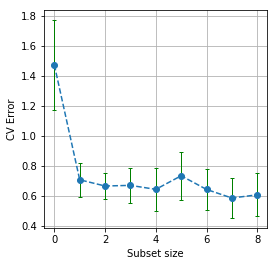

In [135]:
figWidth = 4
figHeight = 4
fig = plt.figure(figsize=(figWidth,figHeight))

plt.errorbar(candidateMs, cvErrors, yerr = cvStdevs, fmt='--o', ecolor='g', elinewidth = 1, \
             capsize = 2)
plt.grid(True)
plt.xlabel("Subset size")
plt.ylabel("CV Error")
plt.show()

In [136]:
oneSdIndex = np.argmax(np.array(cvErrors) - np.array(cvStdevs) <= min(cvErrors))
oneSdPar = candidateMs[oneSdIndex]
print("Parameter chosen by the 1-sd rule: " + str(oneSdPar))

Parameter chosen by the 1-sd rule: 2


In [137]:
# creating final model and assessing error
model.M = oneSdPar
model.train(X_train, Y_train)
testStats = RsStats(model, X_test, Y_test)
model.testError = testStats["avg"]
model.testErrorStdev = testStats["stdev"]
tunedModels["Best subset"] = model

## Ridge

In [220]:
dofMin = 0
dofMax = X_train.shape[1]
NFolds = 10
cvStats = lambda Y, Yhat: [Y.shape[0], np.average((Y - Yhat)*(Y - Yhat))]

model = Ridge(ndof = 0)

stats = {}
candidateDofs = np.array(range(dofMin, dofMax + 1))
for dofs in candidateDofs:
    # fix the lambda outside the model instead of dof-dependent lambda...
    model.ndof = dofs
    stats[dofs] = CVStats(model, X_train, Y_train, NFolds, cvStats, permute = True, seed = 0)
    
cvErrors = [sum([x[1] * x[0] for x in value]) / X_train.shape[0] for key, value in stats.items()]
cvStdevs = [np.sqrt(np.var([x[1] for x in value]) / NFolds) for key, value in stats.items()]

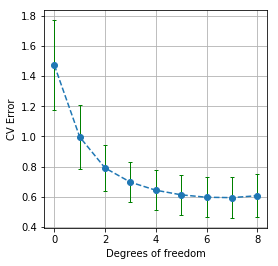

In [221]:
figWidth = 4
figHeight = 4
fig = plt.figure(figsize=(figWidth,figHeight))

plt.errorbar(candidateDofs, cvErrors, yerr = cvStdevs, fmt='--o', ecolor='g', elinewidth = 1, \
             capsize = 2)
plt.grid(True)
plt.xlabel("Degrees of freedom")
plt.ylabel("CV Error")
plt.show()

In [222]:
oneSdIndex = np.argmax(np.array(cvErrors) - np.array(cvStdevs) <= min(cvErrors))
oneSdPar = candidateDofs[oneSdIndex]
print("Parameter chosen by the 1-sd rule: " + str(oneSdPar))

Parameter chosen by the 1-sd rule: 3


In [223]:
# creating final model and assessing error
model.dofs = oneSdPar
model.train(X_train, Y_train)
testStats = RsStats(model, X_test, Y_test)
model.testError = testStats["avg"]
model.testErrorStdev = testStats["stdev"]
tunedModels["Ridge"] = model

## Lasso

In [52]:
class LASSO:
    def __init__(self, Ym, coeffs):
        self.Ym = Ym
        self.coeffs = coeffs
        
    def __init__(self, fractionalArcLength):
        self.fractionalArcLength = fractionalArcLength
        
    def train(self, X, Y):
        path = LASSOPath()
        path.train(X, Y)
        self.Ym = path.Ym
        self.coeffs = np.expand_dims(path.getBeta(self.fractionalArcLength * path.totalArcLength), axis = 1)
        
    def predict(self, X):
        return self.Ym + np.dot(X, self.coeffs)

# demeaning and normalisation are on by default
class LASSOPath:       
    
    def train(self, X, Y):
        y = Y[:,0]
        p = X.shape[1]
        self.Xm = np.expand_dims(np.average(X, axis = 0), axis = 0)
        Xdm = X - self.Xm
        self.Ym = np.expand_dims(np.average(Y, axis = 0), axis = 0)
        self.Xvar = np.expand_dims(np.average(Xdm * Xdm, axis = 0), axis = 0)
        
        self.Xsd = np.sqrt(self.Xvar)
        Z = Xdm / self.Xsd
        
        r = y.copy()        
        corrs = np.dot(Z.T, r)
        acorrs = np.abs(corrs)
        
        activeSet = [np.argmax(corrs)]
        inactiveSet = list(set(range(p)) - set(activeSet))
        beta = np.zeros((X.shape[1]))
        
        betasList = [beta.copy()]
        
        while True:
            Zr = Z[:,activeSet]           
            Zi = Z[:,inactiveSet]
            na = Zr.shape[1]
            ni = Zi.shape[1]
            
            # 1) find OLS direction
            acorrs_active = acorrs[activeSet]
            #print("Active set absolute correlations: " + str(acorrs_active.flatten()))
            acorr_active = acorrs_active[0]
            acorrs_inactive = acorrs[inactiveSet]
            delta = np.dot(np.dot(np.linalg.inv(np.dot(Zr.T, Zr)), Zr.T), r)
            
            # 2) find when any other will reach same value of abs corr
            corrs_inactive = corrs[inactiveSet]            
            dcorrs_inactive = np.dot(Zi.T, np.dot(Zr, delta))            
            
            lambdaMin_inactive = np.zeros((ni)) + np.inf
            
            # it means the correlation keeps increasing, in this case it won't cross
            increasing = dcorrs_inactive * corrs_inactive <= 0
            lambdaMin_inactive[increasing] = \
                (acorr_active - acorrs_inactive[increasing]) / (np.abs(dcorrs_inactive[increasing]) + acorr_active)
            
            decreasing_cr = (dcorrs_inactive * corrs_inactive > 0) & (np.abs(dcorrs_inactive / corrs_inactive) > 1)
            decreasing_ncr = (dcorrs_inactive * corrs_inactive > 0) & (np.abs(dcorrs_inactive / corrs_inactive) < 1)
            
            lambdaMin_inactive[decreasing_ncr] = \
                (acorrs_inactive[decreasing_ncr] - acorr_active) / (np.abs(dcorrs_inactive[decreasing_ncr]) - acorr_active)
            lambdaMin_inactive[decreasing_cr] = \
                (acorrs_inactive[decreasing_cr] + acorr_active) / (np.abs(dcorrs_inactive[decreasing_cr]) + acorr_active)
            
            if(len(activeSet) < p):
                inactiveIndex = np.argmin(lambdaMin_inactive)
                lambdaNext = lambdaMin_inactive[inactiveIndex]
            else:
                lambdaNext = 1.0
                
            candidateBeta = beta.copy()
            candidateBeta[activeSet] = beta[activeSet] + lambdaNext * delta
                
            # check if any coefficient crosses zero            
            activeCrossing = ((candidateBeta * beta < 0))[activeSet]
            crossLambdaActive = np.zeros((na)) + np.inf
            crossLambdaActive[activeCrossing] = (beta[activeSet])[activeCrossing] / delta[activeCrossing]
            firstCrossActiveIndex = np.argmin(crossLambdaActive)
            
            crossing = False
            if crossLambdaActive[firstCrossActiveIndex] < lambdaNext: # found a crossing
                print("Crossing detected")
                lambdaNext = crossLambdaActive[firstCrossActiveIndex]
                crossPred = activeSet[firstCrossActiveIndex]
                crossing = True   
            
            beta[activeSet] = beta[activeSet] + lambdaNext * delta
            betasList.append(beta.copy())
            
            if(lambdaNext == 1.0):
                break
            
            # updating correlations and residuals
            r = r - lambdaNext * np.dot(Zr, delta)
            corrs = np.dot(Z.T, r)
            acorrs = np.abs(corrs)
            
            if crossing:
                activeSet = list(set(activeSet) - {crossPred})
            else:
                activeSet.append(inactiveSet[inactiveIndex])
                
            inactiveSet = list(set(range(p)) - set(activeSet))
            
        self.betasList = [beta / self.Xsd.flatten() for beta in betasList]
        
        self.storeArcLengths()
        
    def storeArcLengths(self):
        self.arcLengths = [0]
        nb = len(self.betasList)
        self.nNodes = nb
        
        for i in range(1, nb):
            db = self.betasList[i] - self.betasList[i - 1]
            self.arcLengths.append(self.arcLengths[i - 1] + np.linalg.norm(db, ord = 1))
            #print(self.arcLengths[i] / np.linalg.norm(self.betasList[i], ord = 1))
            
        self.totalArcLength = self.arcLengths[nb - 1]
        #self.arcLengths = [self.totalArcLength - l for l in self.arcLengths]
        
        #print(self.arcLengths)
        #self.arcLengths = list(reversed(self.arcLengths))
        #self.betasList = list(reversed(self.betasList))
        
    def getBeta(self, arcLength):
        if arcLength >= self.totalArcLength:
            return self.betasList[self.nNodes - 1]
        lIndex = np.searchsorted(self.arcLengths, arcLength, side = 'right') - 1
        dLength = arcLength - self.arcLengths[lIndex]
        
        return self.betasList[lIndex] + \
            (self.betasList[lIndex + 1] - self.betasList[lIndex]) * \
            dLength / np.linalg.norm(self.betasList[lIndex + 1] - self.betasList[lIndex], ord = 1)
            
    def getModel(self, fractionalArcLength):
        return LASSO(self.Ym, np.expand_dims(self.getBeta(fractionalArcLength * self.totalArcLength), axis = 1))

In [53]:
NFolds = 10#X_train.shape[0]
cvStats = lambda Y, Yhat: [Y.shape[0], np.average((Y - Yhat)*(Y - Yhat))]

model = LASSO(fractionalArcLength = 0)

stats = {}
shrinkageFactors = np.linspace(0, 1, 10)
for shr in shrinkageFactors:
    # fix the lambda outside the model instead of dof-dependent lambda...
    model.fractionalArcLength = shr
    stats[shr] = CVStats(model, X_train, Y_train, NFolds, cvStats, permute = True, seed = 6)
    
cvErrors = [sum([x[1] * x[0] for x in value]) / X_train.shape[0] for key, value in stats.items()]
cvStdevs = [np.sqrt(np.var([x[1] for x in value]) / NFolds) for key, value in stats.items()]

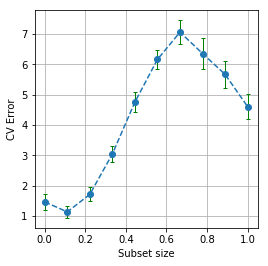

In [54]:
figWidth = 4
figHeight = 4
fig = plt.figure(figsize=(figWidth,figHeight))

plt.errorbar(shrinkageFactors, cvErrors, yerr = cvStdevs, fmt='--o', ecolor='g', elinewidth = 1, \
             capsize = 2)
plt.grid(True)
plt.xlabel("Subset size")
plt.ylabel("CV Error")
plt.show()

In [55]:
oneSdIndex = np.argmax(np.array(cvErrors) - np.array(cvStdevs) <= min(cvErrors))
oneSdPar = shrinkageFactors[oneSdIndex]
print("Parameter chosen by the 1-sd rule: " + str(oneSdPar))

Parameter chosen by the 1-sd rule: 0.111111111111


In [56]:
# creating final model and assessing error
model.fractionalArcLength = oneSdPar
model.train(X_train, Y_train)
testStats = RsStats(model, X_test, Y_test)
model.testError = testStats["avg"]
model.testErrorStdev = testStats["stdev"]
tunedModels["Lasso"] = model

## PCR

In [57]:
class PCR:
    def __init__(self, normalise, K):
        self.normalise = True
        self.K = K
        
    def train(self, X, Y):
        self.Ym = np.expand_dims(np.average(Y, axis = 0), axis = 0)
        self.Xm = np.expand_dims(np.average(X, axis = 0), axis = 0)
        Xdm = X - self.Xm
        
        p = X.shape[1]
        self.Xnorms = np.expand_dims(\
            np.sqrt(np.average(Xdm * Xdm, axis = 0)) if self.normalise else (1 + np.zeros((p))),\
            axis = 0)
        
        Z = Xdm / self.Xnorms
        U, D, V = np.linalg.svd(Z)
        U = U[:,0:p]
        
        Ucoeffs = np.dot(U.T, Y)
        
        # filter
        Ucoeffs[K:p,:] = 0
        
        Zcoeffs = np.dot(V.T, np.dot(np.diag(1.0/D), Ucoeffs))
        self.coeffs = Zcoeffs / self.Xnorms.T
        
    def predict(self, X):
        return self.Ym + np.dot((X - self.Xm), self.coeffs)

In [58]:
NFolds = 10#X_train.shape[0]
cvStats = lambda Y, Yhat: [Y.shape[0], np.average((Y - Yhat)*(Y - Yhat))]

model = PCR(normalise = False, K = 0)

stats = {}
Ks = list(range(9))
for K in Ks:
    # fix the lambda outside the model instead of dof-dependent lambda...
    model.K = K
    stats[K] = CVStats(model, X_train, Y_train, NFolds, cvStats, permute = True, seed = 6)
    
cvErrors = [sum([x[1] * x[0] for x in value]) / X_train.shape[0] for key, value in stats.items()]
cvStdevs = [np.sqrt(np.var([x[1] for x in value]) / NFolds) for key, value in stats.items()]

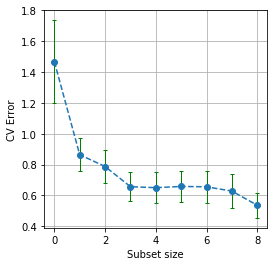

In [59]:
figWidth = 4
figHeight = 4
fig = plt.figure(figsize=(figWidth,figHeight))

plt.errorbar(Ks, cvErrors, yerr = cvStdevs, fmt='--o', ecolor='g', elinewidth = 1, \
             capsize = 2)
plt.grid(True)
plt.xlabel("Subset size")
plt.ylabel("CV Error")
plt.show()

In [60]:
oneSdIndex = np.argmax(np.array(cvErrors) - np.array(cvStdevs) <= min(cvErrors))
oneSdPar = Ks[oneSdIndex]
print("Parameter chosen by the 1-sd rule: " + str(oneSdPar))

Parameter chosen by the 1-sd rule: 7


In [61]:
# creating final model and assessing error
model.K = oneSdPar
model.train(X_train, Y_train)
testStats = RsStats(model, X_test, Y_test)
model.testError = testStats["avg"]
model.testErrorStdev = testStats["stdev"]
tunedModels["PCR"] = model

## PLS

In [62]:
class PLS:
    def __init__(self, normalise, K):
        self.K = K
        self.normalise = normalise
        
    def train(self, X, Y):
        p = X.shape[1]
        self.Ym = np.expand_dims(np.average(Y, axis = 0), axis = 0)
        self.Xm = np.expand_dims(np.average(X, axis = 0), axis = 0)
        Xdm = X - self.Xm
        self.Xnorms = np.expand_dims(\
            np.sqrt(np.average(Xdm * Xdm, axis = 0)) if self.normalise else (1 + np.zeros((p))),\
            axis = 0) #(1, p)
        Z = Xdm / self.Xnorms
        
        self.linCombs = np.zeros((p, K)) # coefficients of linear combinations of normalised variables
        A = np.identity(p) # Xm = A * X
        Zm = Z
        
        normCoeffs = np.zeros((p, 1))
        self.vs = []
        
        for k in range(self.K):
            mCoeffs = np.dot(Zm.T, Y)
            self.linCombs[:,k:k + 1] = np.dot(A, mCoeffs)
            v = np.dot(Zm, mCoeffs)
            self.vs.append(v)
            
            # coefficients of normalised variables
            plsCoeff = np.dot(v.T, Y) / np.dot(v.T, v)
            normCoeffs = normCoeffs + plsCoeff * self.linCombs[:,k:k + 1]
            
            # residualise and update matrix transformation
            A = A - np.dot(A, np.dot(mCoeffs, np.dot(v.T, Z))/ np.dot(v.T, v)) 
            Zm = np.dot(Z, A)
            
        self.coeffs = normCoeffs / self.Xnorms.T
        
    def predict(self, X):
        return self.Ym + np.dot(X - self.Xm, self.coeffs)

In [30]:
model = PLS(normalise = True, K = 1)
model.train(X_train, Y_train)

In [31]:
NFolds = 10
cvStats = lambda Y, Yhat: [Y.shape[0], np.average((Y - Yhat)*(Y - Yhat))]

model = PLS(normalise = True, K = 0)

stats = {}
Ks = list(range(9))
for K in Ks:
    # fix the lambda outside the model instead of dof-dependent lambda...
    model.K = K
    stats[K] = CVStats(model, X_train, Y_train, NFolds, cvStats, permute = True, seed = 0)
    
cvErrors = [sum([x[1] * x[0] for x in value]) / X_train.shape[0] for key, value in stats.items()]
cvStdevs = [np.sqrt(np.var([x[1] for x in value]) / NFolds) for key, value in stats.items()]

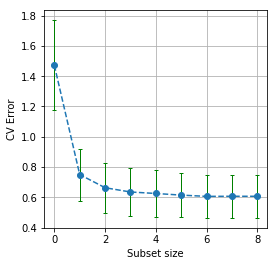

In [32]:
figWidth = 4
figHeight = 4
fig = plt.figure(figsize=(figWidth,figHeight))

plt.errorbar(Ks, cvErrors, yerr = cvStdevs, fmt='--o', ecolor='g', elinewidth = 1, \
             capsize = 2)
plt.grid(True)
plt.xlabel("Subset size")
plt.ylabel("CV Error")
plt.show()

In [33]:
oneSdIndex = np.argmax(np.array(cvErrors) - np.array(cvStdevs) <= min(cvErrors))
oneSdPar = Ks[oneSdIndex]
print("Parameter chosen by the 1-sd rule: " + str(oneSdPar))

Parameter chosen by the 1-sd rule: 1


In [34]:
# creating final model and assessing error
model.K = oneSdPar
model.train(X_train, Y_train)
testStats = RsStats(model, X_test, Y_test)
model.testError = testStats["avg"]
model.testErrorStdev = testStats["stdev"]
tunedModels["PLS"] = model

In [193]:
np.exp(int(2))

7.3890560989306504